In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import cv2
import numpy as np
import tensorflow.keras
import tensorflow as tf
import seaborn as sns
from functools import partial
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense,Flatten
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D,MaxPool2D,Activation
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense,Add, Dropout, Resizing,Rescaling,InputLayer,Flatten,LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,Model
import plotly.express as px
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import L2
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomFlip, RandomContrast
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator





In [4]:
learning_rate = 0.001
class_name=['glioma','meningioma','notumor','pituitary']
weight_decay = 0.0001
num_classes=4
batch_size =32
num_epochs = 100
image_size = 72


In [5]:
train_data='/content/drive/MyDrive/Brain Tumor Segmentation Dataset/image'


In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(image_size,image_size),
    shuffle=True,
    seed=99,
    validation_split=0.2,
    subset='training',
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
    train_data,
    labels='inferred',
    label_mode='categorical',
    class_names=class_name,
    color_mode='grayscale',
    batch_size=batch_size,
    image_size=(image_size,image_size),
    shuffle=True,
    seed=99,
    validation_split=0.2,  # Use 20% of the data for validation
    subset='validation',
)


Found 4267 files belonging to 4 classes.
Using 3414 files for training.
Found 4267 files belonging to 4 classes.
Using 853 files for validation.


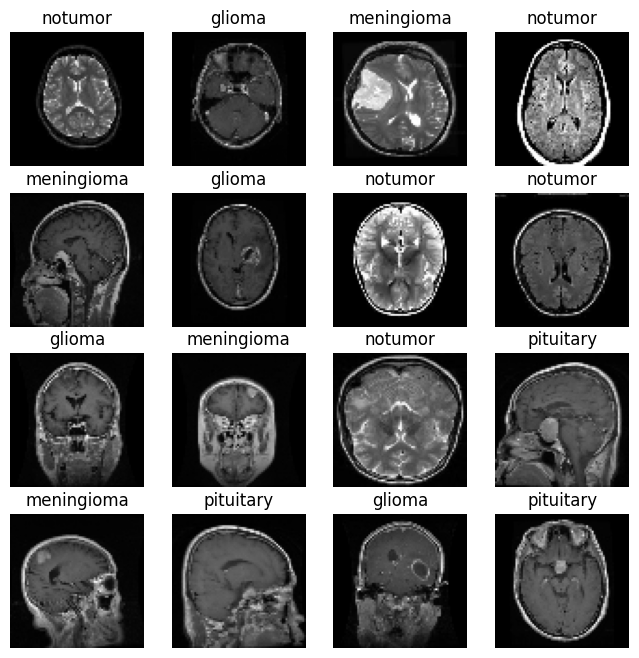

In [7]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(10):
    for i in range(min(16, len(images))):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i] / 255., cmap='gray')
        plt.title(class_name[tf.argmax(labels[i]).numpy()])
        plt.axis("off")

plt.show()


In [8]:
train_datagen = image.ImageDataGenerator(
    rescale = 1./255,rotation_range=30,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,validation_split = 0.20
 )

valid_datagen = image.ImageDataGenerator(rescale=1./255,validation_split = 0.20)

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size = (180,180),
    batch_size = 32,subset = 'training',
     class_mode = 'categorical')

Found 3416 images belonging to 4 classes.


In [10]:
validation_generator = valid_datagen.flow_from_directory(
    train_data,
    target_size = (180,180),
    batch_size = 32,subset = 'validation',
    class_mode = 'categorical')

test_datagen  = image.ImageDataGenerator(rescale = 1./255)
test_dataset  = test_datagen.flow_from_directory(train_data,
                                                 target_size = (180,180),
                                                 class_mode = 'categorical',
                                                 batch_size = 32,
                                                 shuffle=False)

Found 851 images belonging to 4 classes.
Found 4267 images belonging to 4 classes.


In [11]:
input_tensor = Input(shape=(180,180, 3))
base_model = tensorflow.keras.applications.InceptionResNetV2(input_tensor=input_tensor, weights='imagenet', include_top=False)
model=Sequential()
model.add(base_model)
#model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(1024,kernel_initializer='he_uniform'))
#model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax'))

219055592/219055592 [==============================] - 1s 0us/step


In [12]:
for layer in base_model.layers:
  layer.trainable = False

In [13]:

model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [14]:
history=model.fit(train_generator,
                        validation_data=validation_generator,
                        epochs = 20,
                        verbose = 1)
model.save("/content/drive/MyDrive/outmodel")

Epoch 1/20
107/107 [==============================] - 924s 8s/step - loss: 0.5740 - accuracy: 0.8103 - val_loss: 0.7559 - val_accuracy: 0.7156
Epoch 2/20
107/107 [==============================] - 753s 7s/step - loss: 0.2995 - accuracy: 0.8885 - val_loss: 0.7634 - val_accuracy: 0.7861
Epoch 3/20
107/107 [==============================] - 736s 7s/step - loss: 0.2608 - accuracy: 0.9060 - val_loss: 0.5662 - val_accuracy: 0.8367
Epoch 4/20
107/107 [==============================] - 713s 7s/step - loss: 0.2032 - accuracy: 0.9245 - val_loss: 0.5174 - val_accuracy: 0.8472
Epoch 5/20
107/107 [==============================] - 729s 7s/step - loss: 0.1800 - accuracy: 0.9388 - val_loss: 0.7155 - val_accuracy: 0.8214
Epoch 6/20
107/107 [==============================] - 725s 7s/step - loss: 0.1785 - accuracy: 0.9371 - val_loss: 0.3965 - val_accuracy: 0.8837
Epoch 7/20
107/107 [==============================] - 726s 7s/step - loss: 0.1505 - accuracy: 0.9494 - val_loss: 0.3955 - val_accuracy: 0.8860

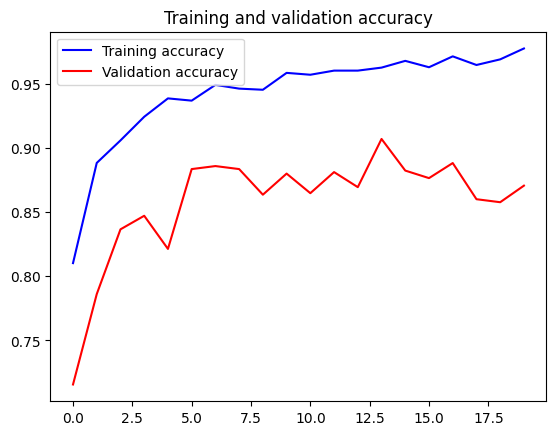

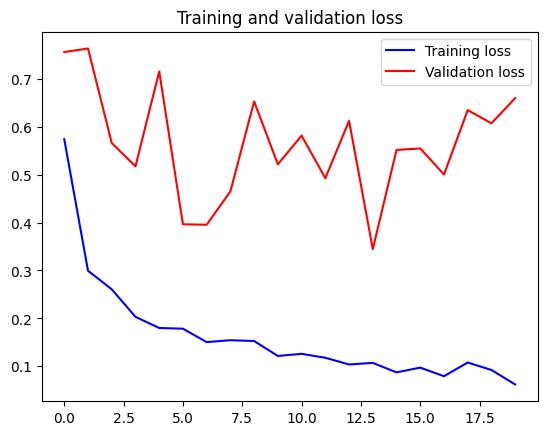

In [17]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

134/134 [==============================] - 629s 5s/step


<Axes: >

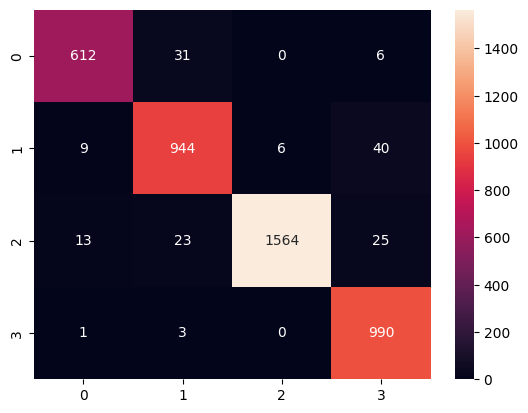

In [18]:
y_true=[]
pred=[]

y_true = test_dataset.classes
pred = np.argmax(model.predict(test_dataset), axis=1)
from sklearn import metrics
cm=metrics.confusion_matrix(y_true, pred)
import seaborn as sns
sns.heatmap(cm,fmt="d",annot=True)

In [40]:
from sklearn import metrics

# Compute accuracy
accuracy = metrics.accuracy_score(y_true, pred) * 100

# Compute precision, recall, F1-score
precision = metrics.precision_score(y_true, pred, average='weighted') * 100
recall = metrics.recall_score(y_true, pred, average='weighted') * 100
f1_score = metrics.f1_score(y_true, pred, average='weighted') * 100

# Print the computed metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Accuracy: 96.32059995312866
Precision: 96.41153303358814
Recall: 96.32059995312866
F1 Score: 96.32938464066953


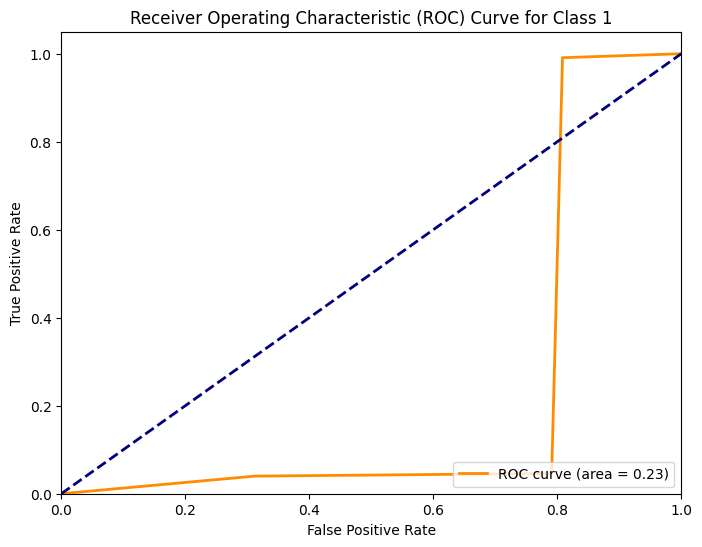

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_true and pred are defined

# Assuming pred contains class labels, you need to convert it to probabilities
# Replace this line with your actual prediction method if needed
# pred_prob = model.predict_proba(test_dataset)

# Choose a specific class for ROC curve
positive_class = 1  # For example, let's choose class 1

# Compute ROC curve for the selected class
fpr, tpr, thresholds = roc_curve((y_true == positive_class), pred)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Class {}'.format(positive_class))
plt.legend(loc="lower right")
plt.show()


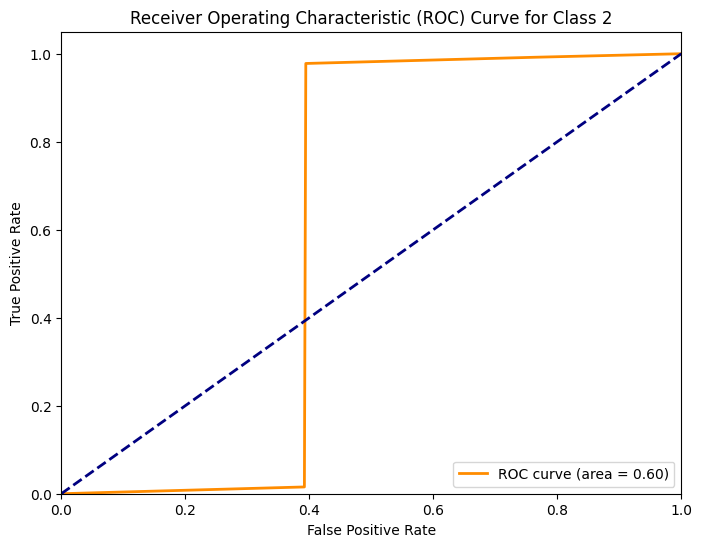

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_true and pred are defined

# Assuming pred contains class labels, you need to convert it to probabilities
# Replace this line with your actual prediction method if needed
# pred_prob = model.predict_proba(test_dataset)

# Choose a specific class for ROC curve
positive_class = 2  # For example, let's choose class 1

# Compute ROC curve for the selected class
fpr, tpr, thresholds = roc_curve((y_true == positive_class), pred)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Class {}'.format(positive_class))
plt.legend(loc="lower right")
plt.show()


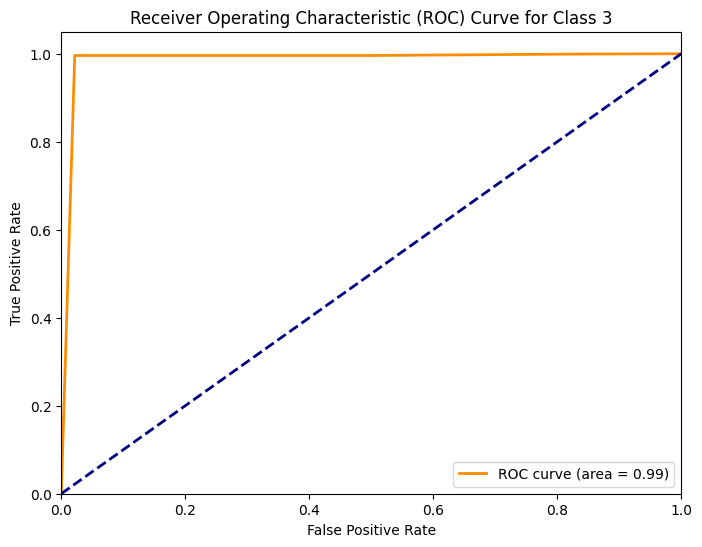

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_true and pred are defined

# Assuming pred contains class labels, you need to convert it to probabilities
# Replace this line with your actual prediction method if needed
# pred_prob = model.predict_proba(test_dataset)

# Choose a specific class for ROC curve
positive_class = 3  # For example, let's choose class 1

# Compute ROC curve for the selected class
fpr, tpr, thresholds = roc_curve((y_true == positive_class), pred)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Class {}'.format(positive_class))
plt.legend(loc="lower right")
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


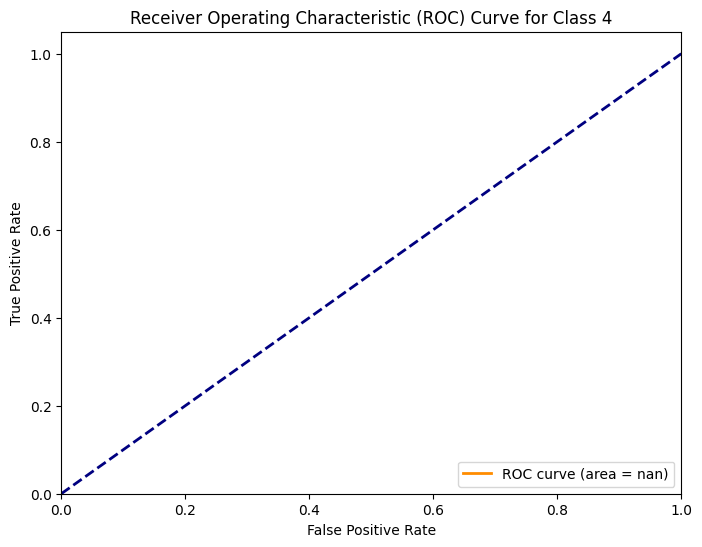

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_true and pred are defined

# Assuming pred contains class labels, you need to convert it to probabilities
# Replace this line with your actual prediction method if needed
# pred_prob = model.predict_proba(test_dataset)

# Choose a specific class for ROC curve
positive_class = 4  # For example, let's choose class 1

# Compute ROC curve for the selected class
fpr, tpr, thresholds = roc_curve((y_true == positive_class), pred)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Class {}'.format(positive_class))
plt.legend(loc="lower right")
plt.show()


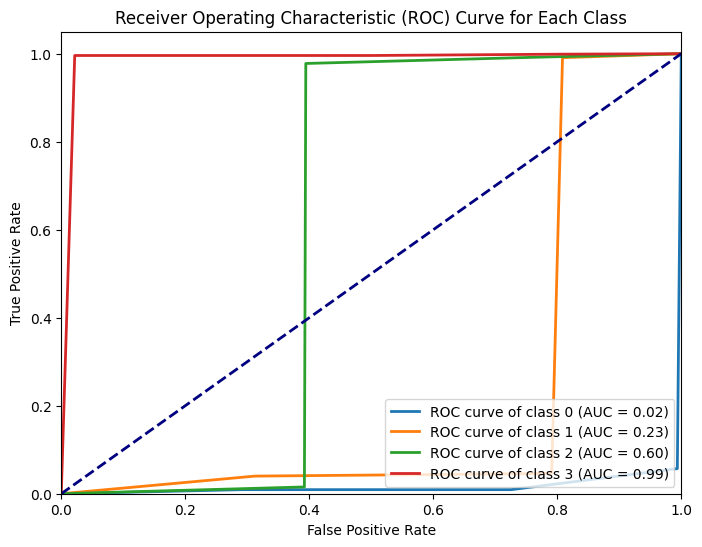

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_true and pred are defined
# Ensure that pred_prob is correctly defined and contains predicted probabilities

n_classes = len(np.unique(y_true))

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    # Compute ROC curve for each class
    # Make sure pred_prob is correctly indexed to access predicted probabilities for each class
    fpr, tpr, _ = roc_curve((y_true == i), pred)  # Check this line
    # Compute AUC for each class
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve for each class
    plt.plot(fpr, tpr, lw=2, label='ROC curve of class {} (AUC = {:.2f})'.format(i, roc_auc))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.legend(loc="lower right")
plt.show()


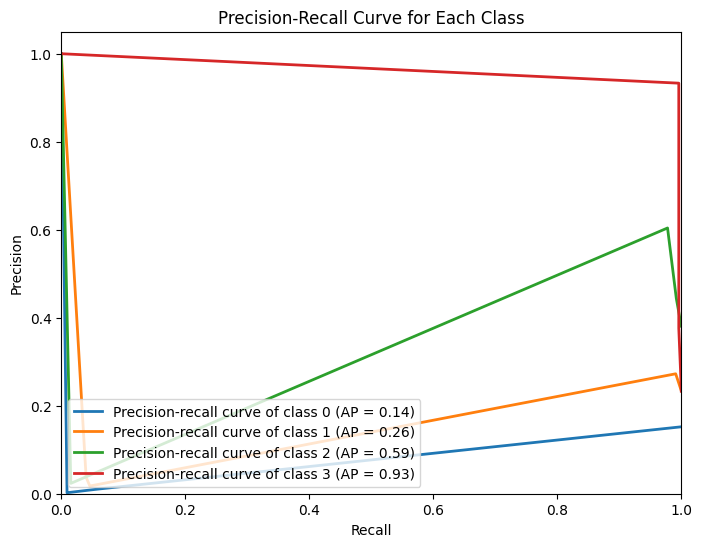

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Assuming y_true and pred are defined

n_classes = len(np.unique(y_true))

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    # Compute precision-recall curve for each class
    precision, recall, _ = precision_recall_curve((y_true == i), pred)
    # Compute average precision for each class
    average_precision = average_precision_score((y_true == i), pred)
    # Plot precision-recall curve for each class
    plt.plot(recall, precision, lw=2, label='Precision-recall curve of class {} (AP = {:.2f})'.format(i, average_precision))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc="lower left")
plt.show()
